# Notebook for analyzing the R&D credit reform
This notebook analyzes the return to full R&D expensing deductibility in Section 174.

## 1. Introduction
Before opening and running this notebook, make sure that you have downloaded or cloned the [`RDcredit2025`](https://github.com/OpenSourceEcon/RDcredit2025) repository (https://github.com/OpenSourceEcon/RDcredit2025) and created and activated the associated conda environment `rdcredit-dev` in the `environment.yml` file.

In [12]:
# import packages
import pandas as pd
import numpy as np
import os
import pickle
import requests
import random
import json
import ccc
import taxcalc as tc
import matplotlib.pyplot as plt

import plotly.express as px

In [13]:
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'data')
image_dir = os.path.join(cur_dir, 'tables_figures')
og_bas_dir = os.path.join(cur_dir, 'RDcreditOutput', 'OUTPUT_BASELINE')
og_ref_retro_dir = os.path.join(
    cur_dir, 'RDcreditOutput', 'OUTPUT_REFORM_RETRO'
)
og_ref_noretro_dir = os.path.join(
    cur_dir, 'RDcreditOutput', 'OUTPUT_REFORM_NORETRO'
)
print(cur_dir)

/Users/richardevans/Docs/Economics/OSE/Federal/RDcredit2025/code


## 1. Full R&D expensing deductibility

The Cost-of-Capital-Calculator model is an open source microsimulation model of business investment incentives. The documentation for the Cost-of-Calculator model is at https://ccc.pslmodels.org and the source code for the model is in the GitHub repository https://github.com/PSLmodels/Cost-of-Capital-Calculator.

### Investment Incentives using Cost of Capital Calculator
Computing the cost-of-capital at the federal level:

Equation for the cost of capital.
$$
\rho = \left[\frac{(r-\pi+\delta)(1-k-u^fz^f-u^sz^s + u^fu^sz^s)}{(1-u^f-u^s+u^fu^s)} + w \right] / (1-\tau^{GR}) - \delta
$$
where:
* $\rho$ = cost of capital
* $r$ = nominal discount rate
* $\pi$ = inflation rate
* $k$ = investment tax credit rate
* $u^f$ = statutory CIT rate at the federal level 
* $u^s$ = statutory CIT rate at the state level 
* $z^f$ = NPV of depreciation deduction under federal system
* $z^s$ = NPV of depreciation deduction under state system
* $w$ = property tax rate
* $\tau^{GR}$ = gross receipts tax rate

Calibration:

| Parameter     | Value | Source |
| ----------- | ----------- |----------- |
| $r$     | 0.06      | To give real return of 4\%|
| $\pi$  | 0.02      | Fed target|
| $k$  | 0.015       | Investment tax credits vary at the federal level by industry and investment type|
| $u^f$  | 0.21       | Federal IRC|
| $u^s$  | 0.05       | Avg. excise tax rate across states|
| $z^f$  | Varies        | Federal IRC|
| $z^s$  |   Varies      | Like Federal IRC, but no bonus deprec |
| $w$  | 0.001       | Average franchise tax rate across states |
| $\tau^{GR}$  | 0.0004 | Average gross receipts tax across states |

### 1.1. Estimate the cost of a year of R&D expensing (without retroactivity)
The JCT May 13, 2025 estimate of the 2025 Budget Reconciliation was only for domestic R&D and had was set to sunset in 2029. The JCT 2025 estimate was the following ($billion):

| 2025 | 2026 | 2027 | 2028 | 2029 | 2025-2029 |
| :---: | :---: | :---: | :---: | :---: | :---: |
| -28.938 | -38.834 | -29.801 | - 20.363 | -10.559 | -128.495|

The average of the first four years is -$29.484 billion per year, and the average of the first five years is -$25.699 billion per year.

The JCT December 18, 2017 of the effects of the Tax Cuts and Jobs Act estimated the effects of replacing the full deductibility of R&D expenses with national and internation amortization schedules as beginning in 2022. The increase in revenue declines in the last two years (2026 and 2027) because all firms are amortizing by then on a 5-year schedule. But the cost in the intial four years was estimated to be the following ($billion):

| 2022 | 2023 | 2024 | 2025 | 2022-2025 |
| :---: | :---: | :---: | :---: | :---: |
| +24.2 | +32.9 | +26.0 | +18.9 | +102.0 |

The average of the first four years is +$25.5 billion per year. If we inflation adjust that 2022-2025 average to the increase in the CBO forecast of the CPI from 2023 to 2026 (+10.7%), or the 2024 to 2026 (7.2%), we get an increase of +$28.229 or +$27.336 billion per year. We choose an estimate in the middle of +$28.0 billion.

The JCT 2014 estimate of the American Research and Competitiveness Act raised the investment tax credit rate 6 percentage points from 14% to 20%. They estimated that this would reduce federal revenue by $19.9 billion in 2023 and $21.3 billion in 2024 (average $20.6 billion). If a 6 percentage point increase in the investment tax credit generates a revenue cost of $20.6 billion in 2023 and 2024, a 7.4 percentage point increase in the investment tax credit would generate a $25.5 billion revenue cost per year revenue. That means that a 53% increase in the investment tax credit rate (7.4/14) is equivalent to restoring full R&D expensing.

#### Setup

Create objects to work with.

In [14]:
# Creating an instance of the Assets class and call it "assets"
assets = ccc.data.Assets()
# Create an instance of the DepreciationParams
# class object and call it dp
dp = ccc.parameters.DepreciationParams()

In [15]:
# define new cost of capital function to take into account state taxes
def eq_coc_state(delta, z_f, z_s, w, u_f, u_s, tau_GR, inv_tax_credit, pi, r):
    r'''
    Compute the cost of capital
    .. math::
        \rho = \frac{\frac{(r-\pi+\delta)}{1-u^f-u^s+u^fu^s}(1-u^fz^f-u^sz^s+u^fu^sz^s)+w}{(1-\tau^GR)}-\delta
    Args:
        delta (array_like): rate of economic depreciation
        z_f (array_like): net present value of depreciation deductions for
            $1 of investment under the federal system
        z_s (array_like): net present value of depreciation deductions for
            $1 of investment under the state system
        w (scalar): property tax rate
        u_f (scalar): statutory marginal tax rate for the first layer of
            income taxes at the federal level
        u_s (scalar): statutory marginal tax rate for the first layer of
            income taxes at the state level
        tau_GR (scalar): gross receipts tax
        inv_tax_credit (scalar): investment tax credit rate
        pi (scalar): inflation rate
        r (scalar): discount rate
    Returns:
        rho (array_like): the cost of capital
    '''
    rho = (
        ((((r - pi + delta) / (1 - u_f - u_s + u_f * u_s)) *
          (1 - inv_tax_credit - u_f * z_f - u_s * z_s + u_f * u_s * z_s) + w) /
         (1 - tau_GR)) - delta
    )

    return rho

Define the baseline model parameters

In [16]:
# Define model parameters
inflation_rate = 0.02 # Inflation rate
nominal_int_rate = 0.06
fraction_financed_w_debt = 0.0
# Specify federal bonus for 2025
federal_bonus_depreciation = {"machines": 0.2, "buildings": 0.0, "intangibles": 0.2}
depreciation_rates = {"machines": 0.1031, "buildings": 0.0314, "intangibles": 0.33}
# Example machine: EI40, example building: SI00, example intangible: ENS3
depreciation_lives = {"machines": 7, "buildings": 39, "intangibles": 3}
depreciation_methods = {"machines": "dbsl", "buildings": "sl", "intangibles": "sl"}
E = 0.06  # Expected after-tax return on corporate equity
profit_rate = 0.2 # 0.2 is a 20% profit rate
int_haircut = 0.0
u_f = 0.21
u_s = 0.05  # Average excise tax rate across states
franchise_tax_rate = 0.001  # Average franchise tax rate across states
tau_GR = 0.0004  # Average gross receipts tax rate across states
# Average federal and state investment tax credit rates
inv_tax_credit_f = {"machines": 0.015, "buildings": 0.025, "intangibles": 0.01}
bonus_s = {"machines": 0.0, "buildings": 0.0, "intangibles": 0.0}

In [17]:
# compute outputs
def compute_outputs(u_s, bonus_s, franchise_tax_rate, tau_GR, inv_tax_credit):
    """
    This function computes the outputs of interest and allows one to change the
    parameters of SC state law

    Args:
      u_s (scalar): statutory marginal tax rate for the first layer of
            income taxes at the state level
      bonus_s (dict): rates of bonus depreciation in TN by asset type
      franchise_tax_rate (scalar): TN franchise tax rate
      excise_tax_rate (scalar): TN excise tax rate
      tau_GR (scalar): gross receipts tax
    """
    out_dict = {"machines": {}, "buildings": {}, "intangibles": {}}
    for k, v in depreciation_rates.items():
        r = ccc.paramfunctions.calc_r(
            u_f + u_s - u_f * u_s, nominal_int_rate, inflation_rate,
            nominal_int_rate, fraction_financed_w_debt, int_haircut, E, 0.0)
        r_prime = ccc.paramfunctions.calc_r_prime(
            nominal_int_rate, inflation_rate, fraction_financed_w_debt, E)
        if depreciation_methods[k] == "dbsl":
            z_f = ccc.calcfunctions.dbsl(depreciation_lives[k], 2, federal_bonus_depreciation[k], r)
            z_s = ccc.calcfunctions.dbsl(depreciation_lives[k], 2, bonus_s[k], r)
        elif depreciation_methods[k] == "sl":
            z_f = ccc.calcfunctions.sl(depreciation_lives[k], federal_bonus_depreciation[k], r)
            z_s = ccc.calcfunctions.sl(depreciation_lives[k], bonus_s[k], r)
        else:
          print("Please enter one of: dbsl, sl")
          assert False
        rho = eq_coc_state(
            depreciation_rates[k], z_f, z_s, franchise_tax_rate, u_f, u_s,
            tau_GR, inv_tax_credit[k], inflation_rate, r
        )
        metr = ccc.calcfunctions.eq_metr(rho, r_prime, inflation_rate)
        eatr = ccc.calcfunctions.eq_eatr(
            rho, metr, profit_rate, u_f + u_s - u_f * u_s
        )
        out_dict[k]["rho"] = rho
        out_dict[k]["metr"] = metr
        out_dict[k]["eatr"] = eatr
    return out_dict

In [18]:
print("Investment tax credit rates current law:", inv_tax_credit_f)
# Current law
base_df = pd.DataFrame(
    compute_outputs(u_s, bonus_s, franchise_tax_rate, tau_GR, inv_tax_credit_f)
)
# Increase federal investment tax credit rate by 53% in each year from 2027 on
# and by 53% + 50% of 53% in 2026
inv_tax_rate_pct_incr_2026 = 0.53 + (0.53 * 0.5)
print(
    "Investment tax credit rate percent increase for 2026:",
    inv_tax_rate_pct_incr_2026
)
inv_tax_credit_f2026 = {
    "machines": 0.015 * (1 + inv_tax_rate_pct_incr_2026 ),
    "buildings": 0.025 * (1 + inv_tax_rate_pct_incr_2026),
    "intangibles": 0.01 * (1 + inv_tax_rate_pct_incr_2026)
}
print("Investment tax credit rates for 2026:", inv_tax_credit_f2026)
print(
    "Average investment tax credit rate for 2026:",
    (
        inv_tax_credit_f2026["machines"] +
        inv_tax_credit_f2026["buildings"] +
        inv_tax_credit_f2026["intangibles"]
    ) / 3
)
# Increas federal investment tax credit rate by 43% from 2027 onward
inv_tax_rate_pct_incr_2027 = 0.53
print(
    "Investment tax credit rate percent increase for 2027:",
    inv_tax_rate_pct_incr_2027
)
inv_tax_credit_f2027 = {
    "machines": 0.015 * (1 + inv_tax_rate_pct_incr_2027),
    "buildings": 0.025 * (1 + inv_tax_rate_pct_incr_2027),
    "intangibles": 0.01 * (1 + inv_tax_rate_pct_incr_2027)
}
print("Investment tax credit rates for 2027:", inv_tax_credit_f2027)
# Compute outputs for 2026
rdcredit_2026_df = pd.DataFrame(
    compute_outputs(
        u_s, bonus_s, franchise_tax_rate, tau_GR, inv_tax_credit_f2026
    )
)
# Compute outputs for 2027
rdcredit_2027_df = pd.DataFrame(
    compute_outputs(
        u_s, bonus_s, franchise_tax_rate, tau_GR, inv_tax_credit_f2027
    )
)

Investment tax credit rates current law: {'machines': 0.015, 'buildings': 0.025, 'intangibles': 0.01}
Investment tax credit rate percent increase for 2026: 0.795
Investment tax credit rates for 2026: {'machines': 0.026924999999999998, 'buildings': 0.044875, 'intangibles': 0.01795}
Average investment tax credit rate for 2026: 0.029916666666666664
Investment tax credit rate percent increase for 2027: 0.53
Investment tax credit rates for 2027: {'machines': 0.022949999999999998, 'buildings': 0.038250000000000006, 'intangibles': 0.015300000000000001}


In [19]:
# Create policy names and put in one dataframe
base_df['Policy'] = "Current Law"
rdcredit_2026_df['Policy'] = "R&D tax credit 2026"
rdcredit_2027_df['Policy'] = "R&D tax credit 2027"
# append dataframes together
df = pd.concat([base_df, rdcredit_2026_df, rdcredit_2027_df])
df.reset_index(inplace=True)
df.rename(columns={"index": "output_var"}, inplace=True)
df = pd.melt(df, id_vars=["Policy", "output_var"], var_name="asset_type")

In [20]:
# Plot Figure 1: Effect of Full R&D expensing deductibility in 2026 on Business
# Incentives to Invest
fig1 = px.bar(
    df[(df["output_var"]=="metr") & (df["asset_type"]=="machines")],
    x="Policy", y="value", color='Policy',
    labels={'value':'Marginal Effective Tax Rate'}, height=400
)
fig1.show()

In [21]:
# Other results
fig2 = px.bar(
    df[(df["output_var"]=="rho") & (df["asset_type"]=="machines")], x="Policy",
    y="value", color='Policy', labels={'value':'Cost of Capital'}, height=400
)
fig2.show()

In [22]:
# Other results
fig3 = px.histogram(
    df[
        (df["output_var"]=="metr") &
        (df['Policy'].isin([
            "Current Law",
            "R&D tax credit"
        ]))
    ], x="asset_type", y="value", color='Policy', barmode='group',
    labels={'asset_type':'Asset Type', 'value': 'Marginal Effective Tax Rate'},
    height=400)
fig3.show()

In [23]:
# compute example results for equipment
r = ccc.paramfunctions.calc_r(
        u_f + u_s - u_f * u_s, nominal_int_rate, inflation_rate,
        nominal_int_rate, fraction_financed_w_debt, int_haircut, E, 0.0)
r_prime = ccc.paramfunctions.calc_r_prime(
    nominal_int_rate, inflation_rate, fraction_financed_w_debt, E)
z_f = ccc.calcfunctions.dbsl(5, 2, 0.8, r)  # 5 year asset, double declining balance, 80% bonus
z_s = ccc.calcfunctions.dbsl(5, 2, 0.0, r)  # 5 year asset, double declining balance, no bonus
rho = eq_coc_state(
        depreciation_rates['machines'], z_f, z_s, franchise_tax_rate,
        u_f, u_s, tau_GR, inv_tax_credit_f["machines"], inflation_rate, r)
metr = ccc.calcfunctions.eq_metr(rho, r_prime, inflation_rate)
eatr = ccc.calcfunctions.eq_eatr(rho, metr, profit_rate, u_f + u_f - u_f * u_s)
print('Machines: rho = ', rho, ', metr = ', metr, ' and eatr = ', eatr)

Machines: rho =  0.06036801500031139 , metr =  0.006096191837838147  and eatr =  0.2877365642884193


In [24]:
# compare to federal
r = ccc.paramfunctions.calc_r(
        u_f + u_s - u_f * u_s, nominal_int_rate, inflation_rate,
        nominal_int_rate, fraction_financed_w_debt, int_haircut, E, 0.0)
r_prime = ccc.paramfunctions.calc_r_prime(
    nominal_int_rate, inflation_rate, fraction_financed_w_debt, E)
z_f = ccc.calcfunctions.dbsl(5, 2, 0.8, r)  # 5 year asset, double declining balance, 80% bonus
psi_f = 0.5
nu_f = 0.05
rho = ccc.calcfunctions.eq_coc(
    depreciation_rates['machines'], z_f, 0.0, u_f, 0.0, inv_tax_credit_f["machines"], psi_f,
    nu_f, inflation_rate, r
)
metr = ccc.calcfunctions.eq_metr(rho, r_prime, inflation_rate)
eatr = ccc.calcfunctions.eq_eatr(rho, metr, profit_rate, u_f + u_f - u_f * u_s)
print('Machines: rho = ', rho, ', metr = ', metr, ' and eatr = ', eatr)

Machines: rho =  0.10320085443037971 , metr =  0.4186094647067426  and eatr =  0.4142005227056961


In [25]:
# Plot Figure 4: Effects of full R&D expensing deductibility in 2026 on
# Business Incentives to Invest
fig4 = px.bar(
    df[(df["output_var"]=="eatr") & (df["asset_type"]=="machines")],
    x="Policy", y="value", color='Policy',
    labels={'value':'Average Effective Tax Rate'}, height=400
)
fig4.show()

## 2. Calculate revenue loss in 2026
To calculate the revenue loss in 2026, which includes the retroactive expensing of R&D costs. We use the same 50% decay rate we used to calculate the investment tax credit increase in 2026. We start with the JCT estimate of a cost of $28.0 billion in 2026 ($25.5B in 2023 dollars). Then we assume that 50% of those business filers claim the credit in 2025, and 50% of those claim the credit in 2024, etc.

In [26]:
cost_in_2027 = 28.0  # annual cost in billions in 2027 and beyond
adherence_rate = 0.5

cost_in_2026 = (
    cost_in_2027 + (cost_in_2027 * adherence_rate) + (cost_in_2027 * (adherence_rate ** 2)) + (cost_in_2027 * (adherence_rate ** 3)) + (cost_in_2027 * (adherence_rate ** 4))
)
print("Cost in 2026:", cost_in_2026)

Cost in 2026: 54.25


Get 2045 debt-to-GDP values from baseline and reform.

In [27]:
tpi_vars_bas = pickle.load(
    open(os.path.join(og_bas_dir, 'TPI', 'TPI_vars.pkl'), 'rb')
)
tpi_vars_retro_ref = pickle.load(
    open(os.path.join(og_ref_retro_dir, 'TPI', 'TPI_vars.pkl'), 'rb')
)
tpi_vars_noretro_ref = pickle.load(
    open(os.path.join(og_ref_noretro_dir, 'TPI', 'TPI_vars.pkl'), 'rb')
)
D_bas = tpi_vars_bas['D']
Y_bas = tpi_vars_bas['Y']
D_retro_ref = tpi_vars_retro_ref['D']
Y_retro_ref = tpi_vars_retro_ref['Y']
D_noretro_ref = tpi_vars_noretro_ref['D']
Y_noretro_ref = tpi_vars_noretro_ref['Y']
debt_to_gdp_bas = D_bas/Y_bas
debt_to_gdp_retro_ref = D_retro_ref/Y_retro_ref
debt_to_gdp_noretro_ref = D_noretro_ref/Y_noretro_ref
debt_to_gdp_2045_bas = debt_to_gdp_bas[2035 - 2026]
debt_to_gdp_2045_retro_ref = debt_to_gdp_retro_ref[2035 - 2026]
debt_to_gdp_2045_noretro_ref = debt_to_gdp_noretro_ref[2035 - 2026]
print("Debt to GDP in 2035 under baseline:", debt_to_gdp_2045_bas)
print(
    "Debt to GDP in 2035 under reference (retro):", debt_to_gdp_2045_retro_ref
)
print(
    "Debt to GDP in 2035 under reference (no retro):",
    debt_to_gdp_2045_noretro_ref
)

Debt to GDP in 2035 under baseline: 1.2914579105653226
Debt to GDP in 2035 under reference (retro): 1.29925625531329
Debt to GDP in 2035 under reference (no retro): 1.298690920317988


## 3. Compare retro and noretro macro time series

Real GDP in 2026 dollars: [31.6406     32.19854473 32.76040852 33.34552546 33.95311172 34.57180201
 35.20891192 35.85216171 36.49671785 37.13918382 37.77955962 38.41810653
 39.05586962 39.69206508 40.32826054 40.96092884 41.59202952 42.22299955
 42.85579849 43.49003442]


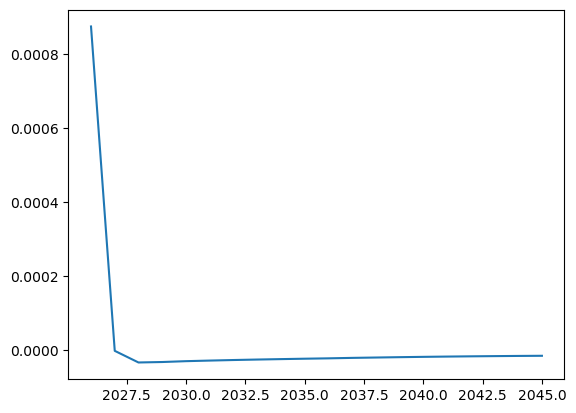

In [28]:
Y_diff_retro_minus_noretro = Y_retro_ref - Y_noretro_ref
plt.plot(np.arange(2026, 2046), Y_diff_retro_minus_noretro[:20])

# Read in real US GDP and nominal US GDP from CBO March 2025 long-term forecast
rgdp_26_45 = np.array(
    [
        24.2205,
        24.6476,
        25.0777,
        25.5256,
        25.9907,
        26.4643,
        26.9520,
        27.4444,
        27.9378,
        28.4296,
        28.9198,
        29.4086,
        29.8968,
        30.3838,
        30.8708,
        31.3551,
        31.8382,
        32.3212,
        32.8056,
        33.2911,
    ]
)

ngdp_26_45 = np.array(
    [
        31.6406,
        32.8410,
        34.0784,
        35.3784,
        36.7388,
        38.1513,
        39.6267,
        41.1542,
        42.7276,
        44.3454,
        46.0104,
        47.7271,
        49.4995,
        51.3250,
        53.2052,
        55.1358,
        57.1209,
        59.1638,
        61.2690,
        63.4381,
    ]
)

r_gdp_26_45_2026dollars = rgdp_26_45 * (ngdp_26_45[0] / rgdp_26_45[0])
print("Real GDP in 2026 dollars:", r_gdp_26_45_2026dollars)

In [29]:
# Compute the dollar change in GDP from 2026 to 2035 with retroactivity
gdp_pct_chg_retro = (Y_retro_ref[:10] - Y_bas[:10]) /  Y_bas[:10]
print("Pct change in GDP from 2026 to 2035 with retroactivity:")
print(np.round(gdp_pct_chg_retro, 5))
r_gdp_dol_chg_retro_26_35_2026dollars = (
    r_gdp_26_45_2026dollars[:10] * gdp_pct_chg_retro * 1_000
)
print("10-year change in real GDP in 2026 dollars ($B, retroactive):")
print(np.round(r_gdp_dol_chg_retro_26_35_2026dollars, 1))
print(
    "10-year total:",
    np.round(np.sum(r_gdp_dol_chg_retro_26_35_2026dollars), 1)
)

Pct change in GDP from 2026 to 2035 with retroactivity:
[0.00289 0.0017  0.00181 0.00179 0.00177 0.00174 0.00171 0.00168 0.00165
 0.00162]
10-year change in real GDP in 2026 dollars ($B, retroactive):
[91.6 54.6 59.4 59.8 59.9 60.  60.1 60.2 60.1 60.1]
10-year total: 625.8


In [30]:
# Compute the dollar change in GDP from 2026 to 2035 without retroactivity
gdp_pct_chg_noretro = (Y_noretro_ref[:10] - Y_bas[:10]) /  Y_bas[:10]
print("Pct change in GDP from 2026 to 2035 without retroactivity:")
print(np.round(gdp_pct_chg_noretro, 5))
r_gdp_dol_chg_noretro_26_35_2026dollars = (
    r_gdp_26_45_2026dollars[:10] * gdp_pct_chg_noretro * 1_000
)
print("10-year change in real GDP in 2026 dollars ($B, no retroactive):")
print(np.round(r_gdp_dol_chg_noretro_26_35_2026dollars, 1))
print(
    "10-year total:",
    np.round(np.sum(r_gdp_dol_chg_noretro_26_35_2026dollars), 1)
)

Pct change in GDP from 2026 to 2035 without retroactivity:
[0.00175 0.0017  0.00186 0.00184 0.0018  0.00177 0.00174 0.00171 0.00168
 0.00165]
10-year change in real GDP in 2026 dollars ($B, no retroactive):
[55.4 54.7 60.9 61.2 61.3 61.3 61.3 61.4 61.3 61.2]
10-year total: 599.9
